<a href="https://colab.research.google.com/github/IHMilon/vision-model-comparison/blob/main/3.%20MobileNet_PlantVillage/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification with MobileNetV2**
---
In this project, I implement and train Custom MobileNetV2 on the PlantVillage dataset for plant disease recognition.

- **Dataset:** PlantVillage (54,000+ images, 38 classes, varying resolutions)  
- **Model:** MobileNetV2 (lightweight, efficient CNN architecture)  
- **Goal:** Achieve high classification accuracy while maintaining computational efficiency

## **Dataset Gathering**
The dataset for this project was obtained from [Kaggle](https://www.kaggle.com/datasets/mohitsingh1804/plantvillage), a popular platform for open datasets and competitions.

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download the PlantVillage Dataset
!kaggle datasets download -d mohitsingh1804/plantvillage 1>/dev/null

In [3]:
# Unzip the the dataset
!unzip /content/plantvillage.zip -d dataset/ 1>/dev/null

## **Package Installation**

In [4]:
!pip install torchprofile 1>/dev/null

## **Import Required libraries**

In [5]:
import os
import time
import random
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR

## **Reproducibility**

In [6]:
torch.manual_seed(50)
np.random.seed(50)
torch.cuda.manual_seed_all(50)

## **Device Setup**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is: {device}")

Device is: cuda


## **Clean & Inspect the Dataset**
Before training, it's important to make sure the dataset is complete and free from any broken or missing samples.
This step ensures the model learns from clean, high-quality data during both training and testing.

In [8]:
# Train and Test Path
train_dir = "/content/dataset/PlantVillage/train"
test_dir = "/content/dataset/PlantVillage/val"

In [9]:
# Check & Clean the Dataset
def inspect_clean(directory):
    removed_files = 0
    total_samples = 0
    for root,_,file in os.walk(directory):
        for f in file:
            path = os.path.join(root,f)
            try:
                image = Image.open(path) # open the image file
                total_samples += 1
                image.verify()
            except Exception as e:
                os.remove(path)
                removed_files += 1
    return total_samples, removed_files

train_total, train_removed = inspect_clean(train_dir)
test_total, test_removed = inspect_clean(test_dir)

print(f"Total train samples: {train_total}, and removed: {train_removed}")
print(f"Total test samples: {test_total}, and removed: {test_removed}")

Total train samples: 43444, and removed: 0
Total test samples: 10861, and removed: 0


The dataset has 43k training samples and 10k val samples and all are correct.

In [10]:
# Show all unique shapes in the dataset
shapes = []
for root, dir, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            shapes.append((img.size[1], img.size[0], len(img.getbands())))  # Height, Width, Channels

unique_shapes = set(shapes)
print(f"Unique shapes (H, W, C) in dataset: {unique_shapes}")

Unique shapes (H, W, C) in dataset: {(256, 256, 4), (256, 256, 3)}


We can see above that the Dataset has inconsistent image shapes. Some samples are in **RGBA** format. So We need to convert them into **RGB**.

In [12]:
# Clean the class names
import re

def clean_name(name):
    name = name.replace("___", " ")
    name = name.replace("_", " ")
    name = re.sub(r"[(),]", "", name)
    name = re.sub(r"[\s_]+", " ", name)
    return name
# Removing the unnecessary parts
for dir in (train_dir, test_dir):
    for folder in os.listdir(dir):
        old_path = os.path.join(dir, folder)
        if os.path.isdir(old_path):
            new_name = clean_name(folder)
            new_path = os.path.join(dir, new_name)
            os.rename(old_path, new_path)

It cleans the class name by removing unnecessary parts from them.

## **Data Augmentation**
To improve generalization, I apply some common image transformations to the PlantVillage training set. The test set is only converted to Tensor.

In [13]:
# Train transformation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
# Test sets are only converted to tensor
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

## **Custom PyTorch Dataset Class for PlantVillage**
Designed a reusable PyTorch `Dataset` class to efficiently load and preprocess image data, ensuring compatibility with deep learning training pipelines.

In [14]:
class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Collecte all class name and sort those
        self.classes = sorted(os.listdir(root_dir))
        # Assign unique label index to every class
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Collect image paths and labels
        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            # Iterate over the files in each folder
            for img_file in os.listdir(cls_folder):
                    # Store all images and their corresponding labels
                    self.image_paths.append(os.path.join(cls_folder, img_file))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        # Dataset size
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get each samples at idx
        img_path = self.image_paths[idx]
        # Convert to RGB as it has RGBA
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        return image, label

## **DataLoader for Training and Testing**
To ensure each batch contains a balanced mix of classes and loads efficiently, I created a custom DataLoader for the dataset.

In [15]:
# Training set
train_dataset = PlantDataset(train_dir, transform = train_transforms)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory = True)

# Testing set
test_dataset = PlantDataset(test_dir, transform = test_transforms)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, pin_memory = True)

## **Visualize training samples from each class**
Helps to ensure that samples are loading perfectly and data Augmentation are applied correctly on each samples.

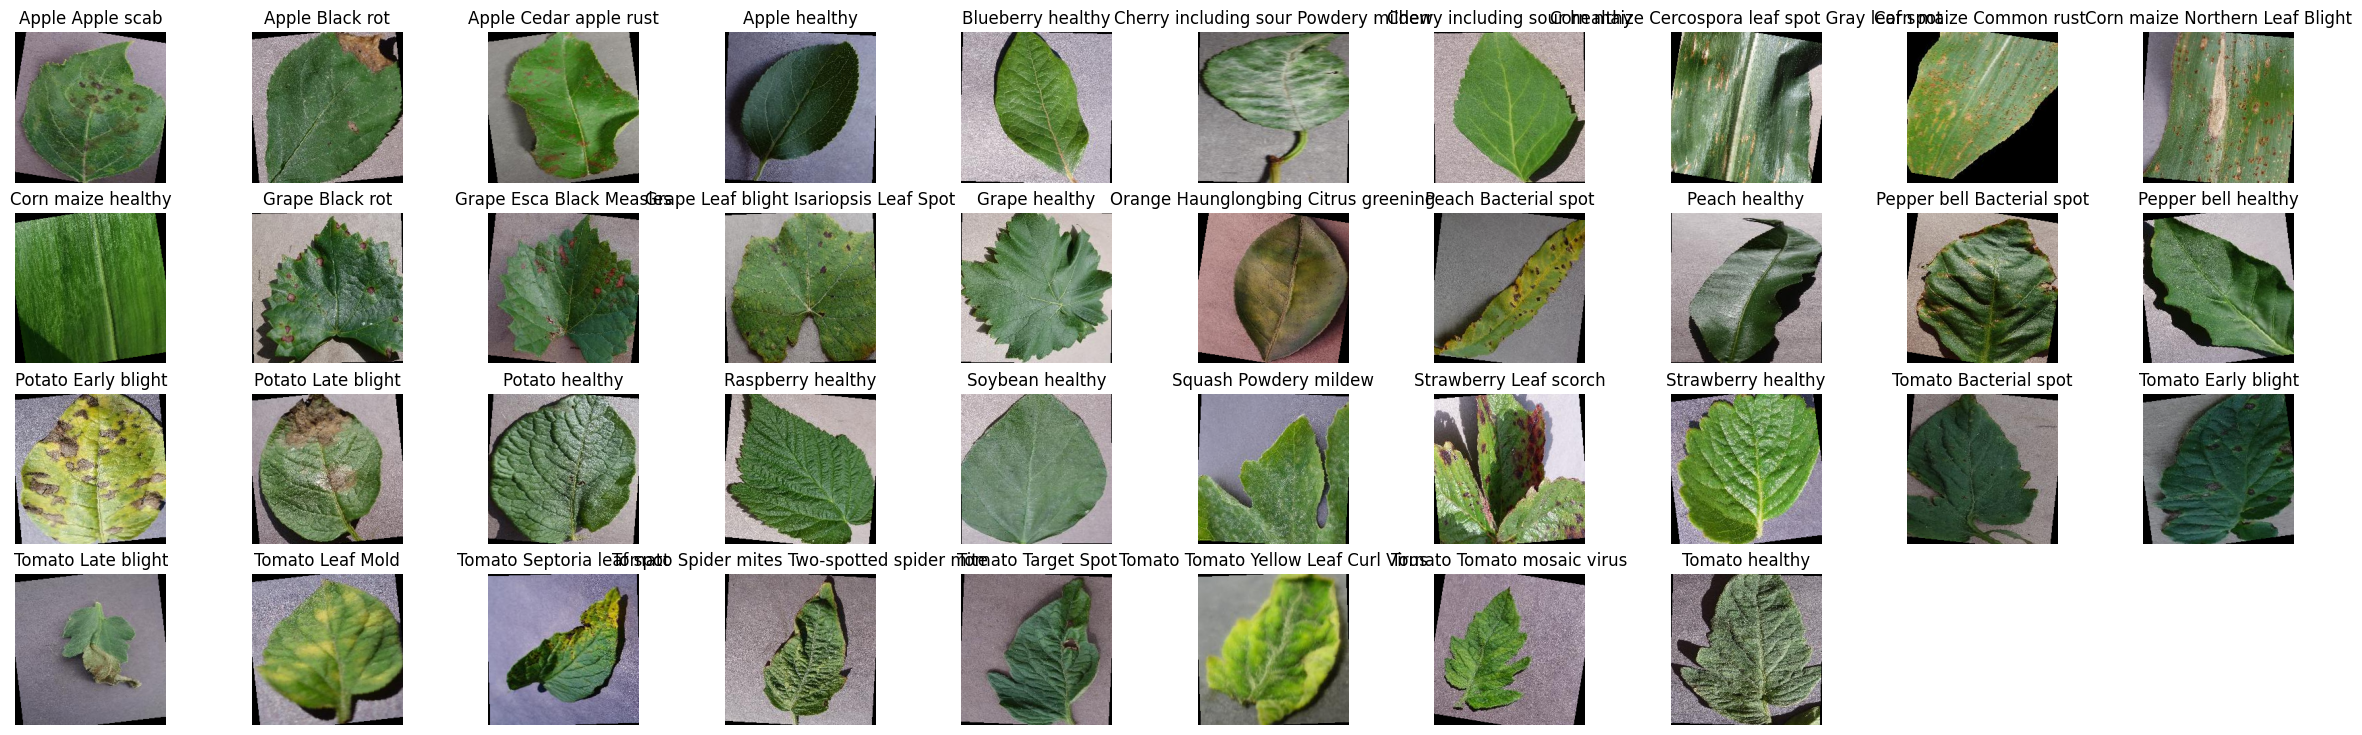

In [16]:
# Collect single sample for each class
samples = [[] for _ in range(38)]
for image, label in train_dataset:
    if len(samples[label]) < 1:
        samples[label].append(image)

plt.figure(figsize = (30,9))
for idx in range(38):
    image = samples[idx][0]
    label = idx

    # Convert from CHW to HWC for visualization
    image = image.permute(1, 2, 0)

    # Convert from class index to class name
    label = train_dataset.classes[label]

    # Visualize the image
    plt.subplot(4, 10, idx + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.show()

## **Inspect Training Batch**
Ensure batches are loading property so that training happens properly.

In [17]:
for images, targets in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Targets shape: {targets.shape}")
    break

Images shape: torch.Size([128, 3, 224, 224])
Targets shape: torch.Size([128])


## **Defining the MobileNetV2 Model**
I implemented the MobileNetV2 architecture from scratch. The model is composed of multiple `Inverted Residual Blocks`, each following the sequence: `Expansion → Depthwise Convolution → Projection`.

In [18]:
# Inverted Residual Block
class Block(nn.Module):
    def __init__(self, expansion, in_channel, out_channel, stride):
        super().__init__()

        hidden_chan = expansion*in_channel
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.stride = stride
        self.expansion = expansion

        # Expansion
        if self.expansion > 1:
            self.conv1 = nn.Conv2d(self.in_channel, hidden_chan, kernel_size = 1, bias = False)
            self.bn1 = nn.BatchNorm2d(hidden_chan)

        # Depthwise Convolution
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, groups = hidden_chan, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(hidden_chan)

        # Linear Projection
        self.conv3 = nn.Conv2d(hidden_chan, self.out_channel, kernel_size = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.out_channel)

        self.relu6 = nn.ReLU6(inplace = True)


    def forward(self, x):
        skip = x
        # applied when channels expands
        if self.expansion > 1:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu6(x)
        # Depthwise Convolution
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu6(x)

        # Linear projection
        x = self.conv3(x)
        x = self.bn3(x)

        # Skip Connection if input = output
        if self.stride == 1 and self.in_channel == self.out_channel:
            x += skip

        return x

### **Full MobileNetV2 model**
At first, single **STEM** layer is applied to reduce the resolution for low cost. Then **Inverted Residual Blocks** layers are used to extract the features from the feature maps. Finally another `Conv2d` use and then goes to `Linear` layer after `AdaptiveAvgPool` layer's processing.

In [19]:
# Full MobileNetV2 Architecture
class MobileNetV2(nn.Module):
    def __init__(self, alpha = 1, num_classes = 38):
        super().__init__()

        self.alpha = alpha
        self.in_channel = int(32*self.alpha)
        self.last_channel = int(1280*self.alpha)

        # model configuration
        expansion = [1, 4, 4, 4, 4, 4, 4]
        out_channel = [16, 24, 32, 64, 96, 160, 320]
        num_blocks = [1, 2, 3, 4, 3, 3, 1]

        # stem layer
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size = 3, stride = 2, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu6 = nn.ReLU6(inplace = True)

        # Inverted Residual Blocks
        self.layer1 = self.make_layer(num_blocks[0], out_channel[0], expansion[0], stride = 1)
        self.layer2 = self.make_layer(num_blocks[1], out_channel[1], expansion[1], stride = 2)
        self.layer3 = self.make_layer(num_blocks[2], out_channel[2], expansion[2], stride = 2)
        self.layer4 = self.make_layer(num_blocks[3], out_channel[3], expansion[3], stride = 2)
        self.layer5 = self.make_layer(num_blocks[4], out_channel[4], expansion[4], stride = 1)
        self.layer6 = self.make_layer(num_blocks[5], out_channel[5], expansion[5], stride = 2)
        self.layer7 = self.make_layer(num_blocks[6], out_channel[6], expansion[6], stride = 1)

        # Final Convolution
        self.convf = nn.Conv2d(self.in_channel, self.last_channel, kernel_size = 1, stride = 1, bias = False)
        self.bnf = nn.BatchNorm2d(self.last_channel)
        self.relu6f = nn.ReLU6(inplace = True)

        self.adap_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(self.last_channel, num_classes)

    def make_layer(self, num_blocks, out_channel, expansion, stride):

        layer = []
        layer.append(Block(expansion, self.in_channel, int(out_channel*self.alpha), stride))

        for _ in range(1, num_blocks):
            self.in_channel = int(out_channel*self.alpha)
            layer.append(Block(expansion, self.in_channel, int(out_channel*self.alpha), stride = 1))

        self.in_channel = int(out_channel*self.alpha)
        return nn.Sequential(*layer)
    def forward(self, x):
        x = self.conv1(x)  #(B, 32, 112, 112)
        x = self.bn1(x)
        x = self.relu6(x)

        x = self.layer1(x)  #(B, 16, 112, 112)
        x = self.layer2(x)  #(B, 24, 56, 56)
        x = self.layer3(x)  #(B, 32, 28, 28)
        x = self.layer4(x)  #(B, 64, 14, 14)
        x = self.layer5(x)  #(B, 96, 14, 14)
        x = self.layer6(x)  #(B, 160, 7, 7)
        x = self.layer7(x)  #(B, 320, 7, 7)

        x = self.convf(x) #(B, 1280, 7, 7)
        x = self.bnf(x)
        x = self.relu6f(x)

        x = self.adap_avg_pool(x).view(x.shape[0], -1)#(B, 1280)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [20]:
model = MobileNetV2(num_classes = 38, alpha = 0.5).to(device)

## **Model Size**
The model size can be estimated by the number of trainable parameters:

In [22]:
num_param=0
# Iterate over the all trainable parameters
for param in model.parameters():
    if param.requires_grad:
        num_param += param.numel()
print(f" Total Parameters: {(num_param/1000000):.3f} Million")

 Total Parameters: 0.447 Million


## **Computational Cost**
The computation cost can be estimated by the number of multiply–accumulate operations (MACs):

In [23]:
# Creating a Dummy tensor
x = torch.zeros(1, 3, 224, 224).to(device)
# Calculate the MACs
macs = profile_macs(model,x)
print(f"#MACs: {(macs/1000000):.2f} Million")

#MACs: 62.28 Million


## **Training Setup**
We use `CrossEntropyLoss` as the loss function, `AdamW` optimizer with weight decay for regularization, and the `OneCycleLR` scheduler for dynamic learning rate adjustment. Also Training is performed with `mixed precision` to accelerate computations and reduce GPU memory usage, following best practices in modern deep learning workflows.

In [31]:
Epochs = 25

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 5e-4)
# LR Scheduler (OneCycleLR)
scheduler = OneCycleLR(optimizer,
            max_lr = 0.01, # highest lr
            steps_per_epoch = len(train_loader), # number of batch/epoch
            epochs = Epochs
            )
# Initialize the scaler to scale loss for Gradient calculation
scaler = GradScaler('cuda')

## **Training Function for one Epoch**
This function handles the training of the model for a single epoch, including forward pass, loss computation, and backpropagation.

In [32]:
def train(model, train_loader, criterion, optimizer, scheduler, scaler, device):

    # Set to training mode
    model.train()
    train_loss = 0
    num_correct = 0
    num_samples = 0
    num_batches = 0
    # Iterate over batches
    for images, labels in train_loader:
        # Move to GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass with Mixed Precision
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scale the loss and update weights
        scaler.scale(loss).backward()
        scaler.step(optimizer)

        # Update the Scaler
        scaler.update()

        # update the lr
        scheduler.step()

        # Convert logits to class index
        preds = outputs.argmax(dim = 1)

        # update the training matrices
        num_batches += 1
        train_loss += loss.item()
        num_samples += labels.size(0)
        num_correct += (preds == labels).sum().item()

    # Get the loss and accuracy
    train_loss = train_loss/num_batches
    train_acc = (num_correct/num_samples)*100

    return train_loss, train_acc

## **Evaluation Function for one Epoch**

In [33]:
def evaluate(model, test_loader, criterion, device):

    # Set to evaluation mode
    model.eval()
    test_loss = 0
    test_samples = 0
    test_correct = 0
    num_batches = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Convert to class index
        preds = outputs.argmax(dim = 1)

        # update test matrices
        num_batches += 1
        test_loss += loss.item()
        test_samples += labels.size(0)
        test_correct += (preds == labels).sum().item()

    # Get the loss and accuracy
    test_loss = test_loss/num_batches
    test_acc = (test_correct/test_samples)*100

    return test_loss, test_acc

## **Train the Model**
The model is trained over multiple epochs, iteratively updating weights using the optimizer while tracking training and validation metrics (loss and accuracy) to monitor learning progress.

In [34]:
# Store the acc & loss for each epoch
train_losses, train_accs = [], []
test_losses, test_accs =[], []

# Finish all GPU works
torch.cuda.synchronize()
# Start time
start_time = time.time()

# Train the model
for epoch in range(1, Epochs+1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, scaler, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    # Store training loss and accs
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # Store test loss and accs
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Print accs every after 5 epoch
    if epoch % 5 == 0:
        print(f"{epoch}. Train Accuracy {train_acc:.2f}%, Test Accuracy {test_acc:.2f}%")
        print("-"*50)

# Complete all GPU works before CPU processing below line
torch.cuda.synchronize()
# Calculate the Training Time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal time to train the model is {(total_time/60):.2f} Minutes")

5. Train Accuracy 86.84%, Test Accuracy 54.33%
--------------------------------------------------
10. Train Accuracy 94.29%, Test Accuracy 68.24%
--------------------------------------------------
15. Train Accuracy 97.22%, Test Accuracy 92.36%
--------------------------------------------------
20. Train Accuracy 99.17%, Test Accuracy 98.90%
--------------------------------------------------
25. Train Accuracy 99.70%, Test Accuracy 99.47%
--------------------------------------------------

Total time to train the model is 64.28 Minutes


## **Loss & Accuracy Plot**
Analyze the model’s performance by comparing training and validation accuracy, as well as their respective loss curves, to assess learning behavior and potential overfitting.

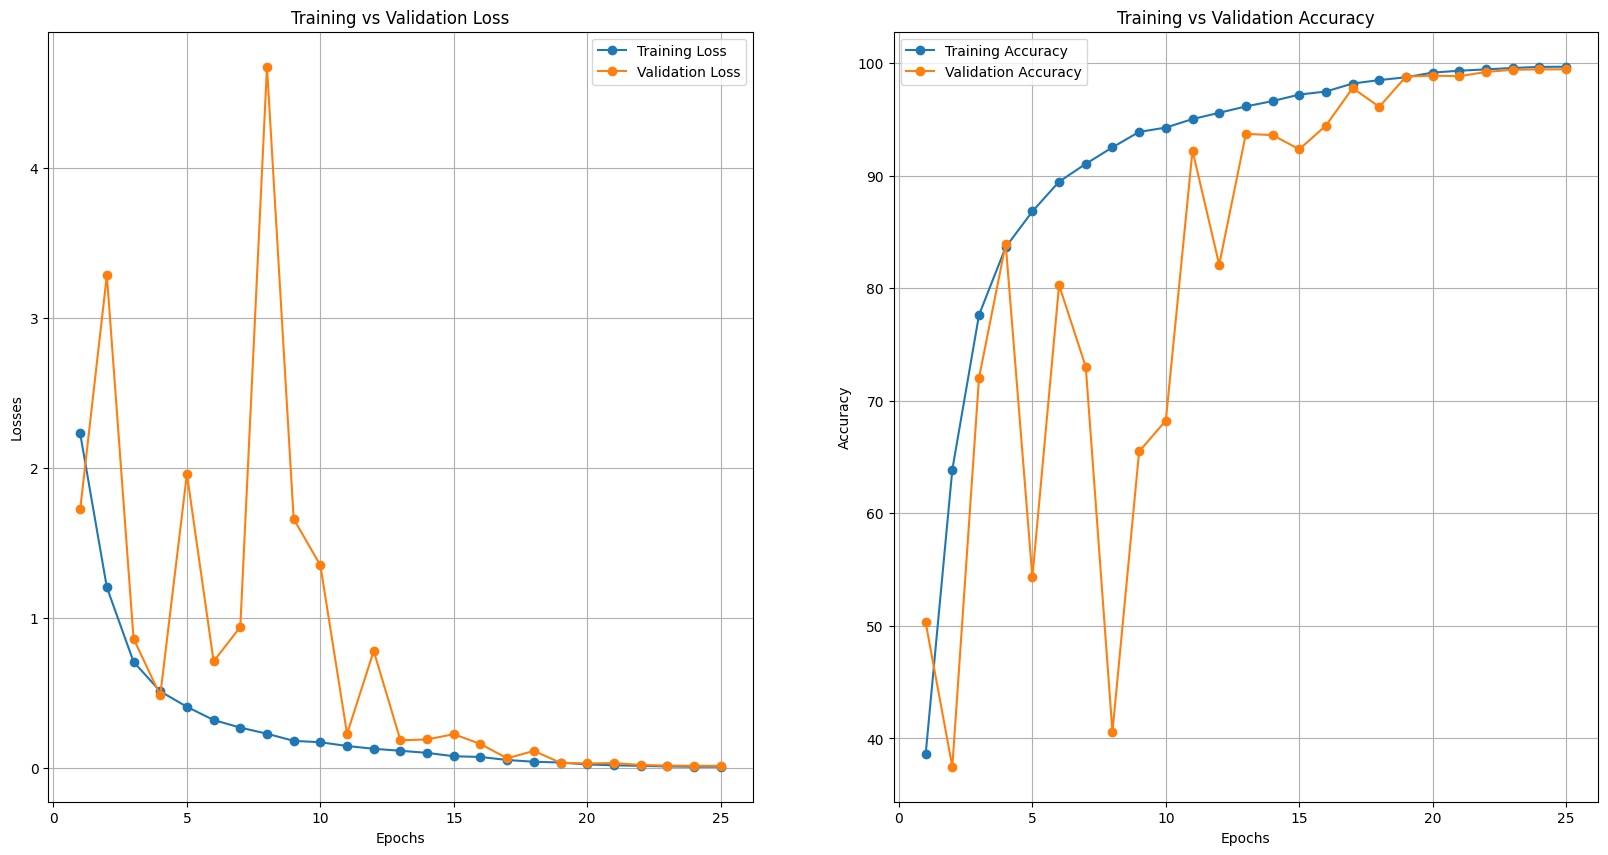

In [35]:
epoch_range = range(1, Epochs+1)
plt.figure(figsize=(20,10))

# Plot the Train and Val Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, train_losses, label = "Training Loss", marker = 'o')
plt.plot(epoch_range, test_losses, label = "Validation Loss", marker = 'o')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot the Train and Val Accuracy
plt.subplot(1,2,2)
plt.plot(epoch_range, train_accs, label = "Training Accuracy", marker = 'o')
plt.plot(epoch_range, test_accs, label = "Validation Accuracy", marker = 'o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()

We can see that the model overfitted till 15 epochs greatly but after that it fixes the overfitting and gains strong accuracy.

## **Predictions Visualization**
We can visualize the model's predictions to see how it performs on test data.

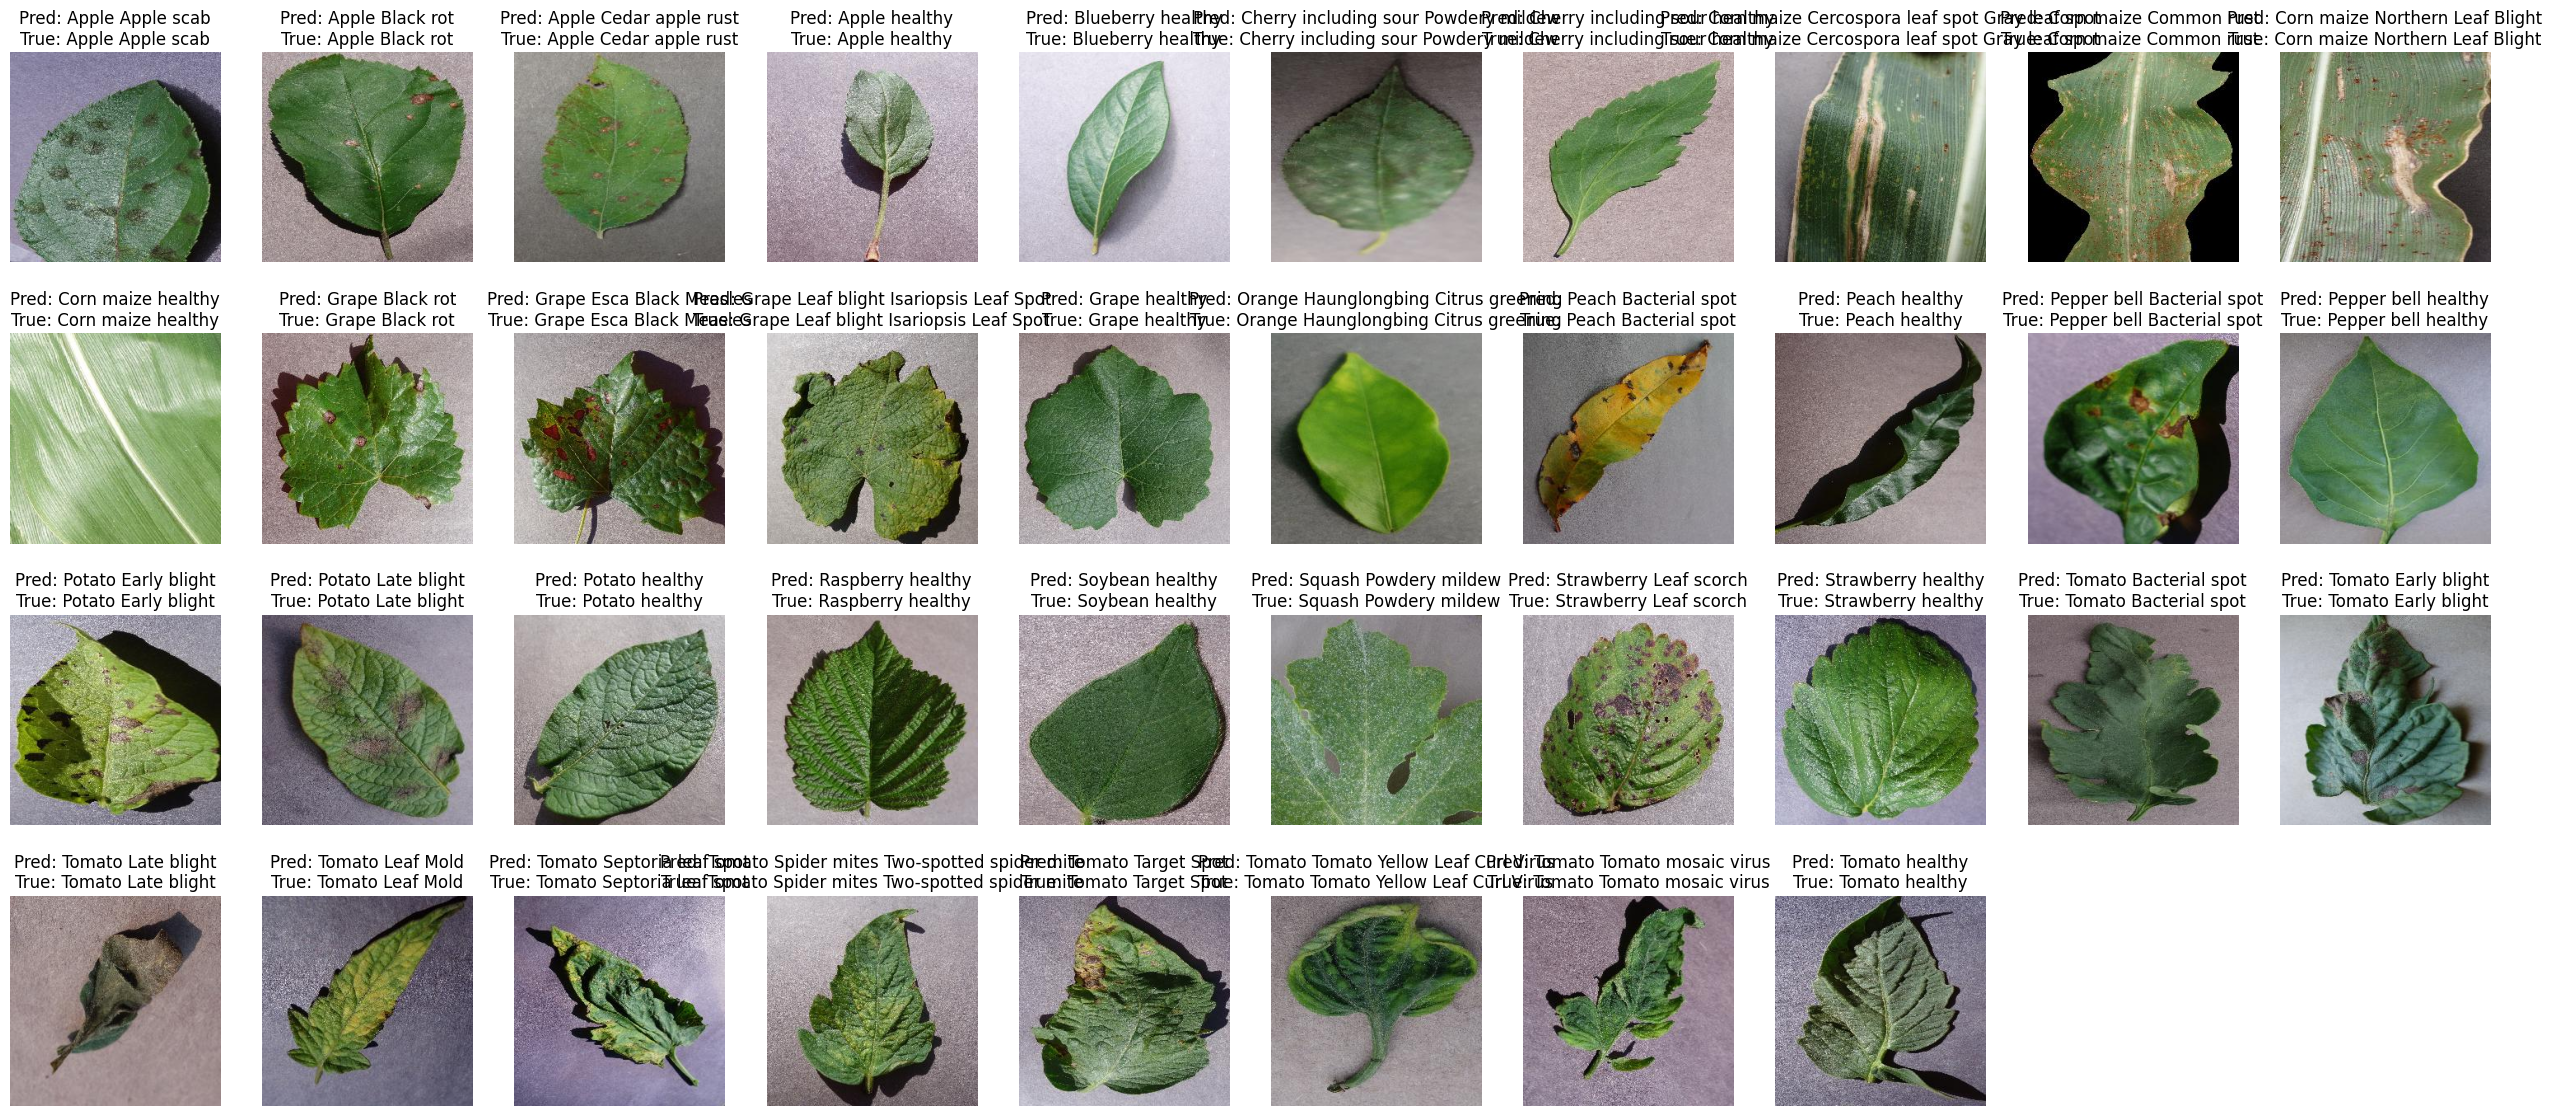

In [36]:
# Get single sample from each class
samples = [ [] for i in range(38)]
for images, labels in test_loader:
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]
        if len(samples[label]) < 1:
            samples[label].append(image)

plt.figure(figsize=(32, 14))
for idx in range (38):
    image = samples[idx][0]
    label = idx

    # Forward pass
    output = model(image.unsqueeze(dim=0).to(device))

    # Convert to label index
    pred = output.argmax(dim=1)

    # Get class name
    true_name = test_dataset.classes[label]
    pred_name = test_dataset.classes[pred.item()]

    # convert CHW to HWC for visualization
    image = image.permute(1,2,0)

    plt.subplot(4,10, idx+1)
    plt.imshow(image)
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}")
    plt.axis("off")
plt.show()

## **Confusion Matrix**
It visualizes the model's performance on the testset. And helps to identify which classes the model confuses the most.

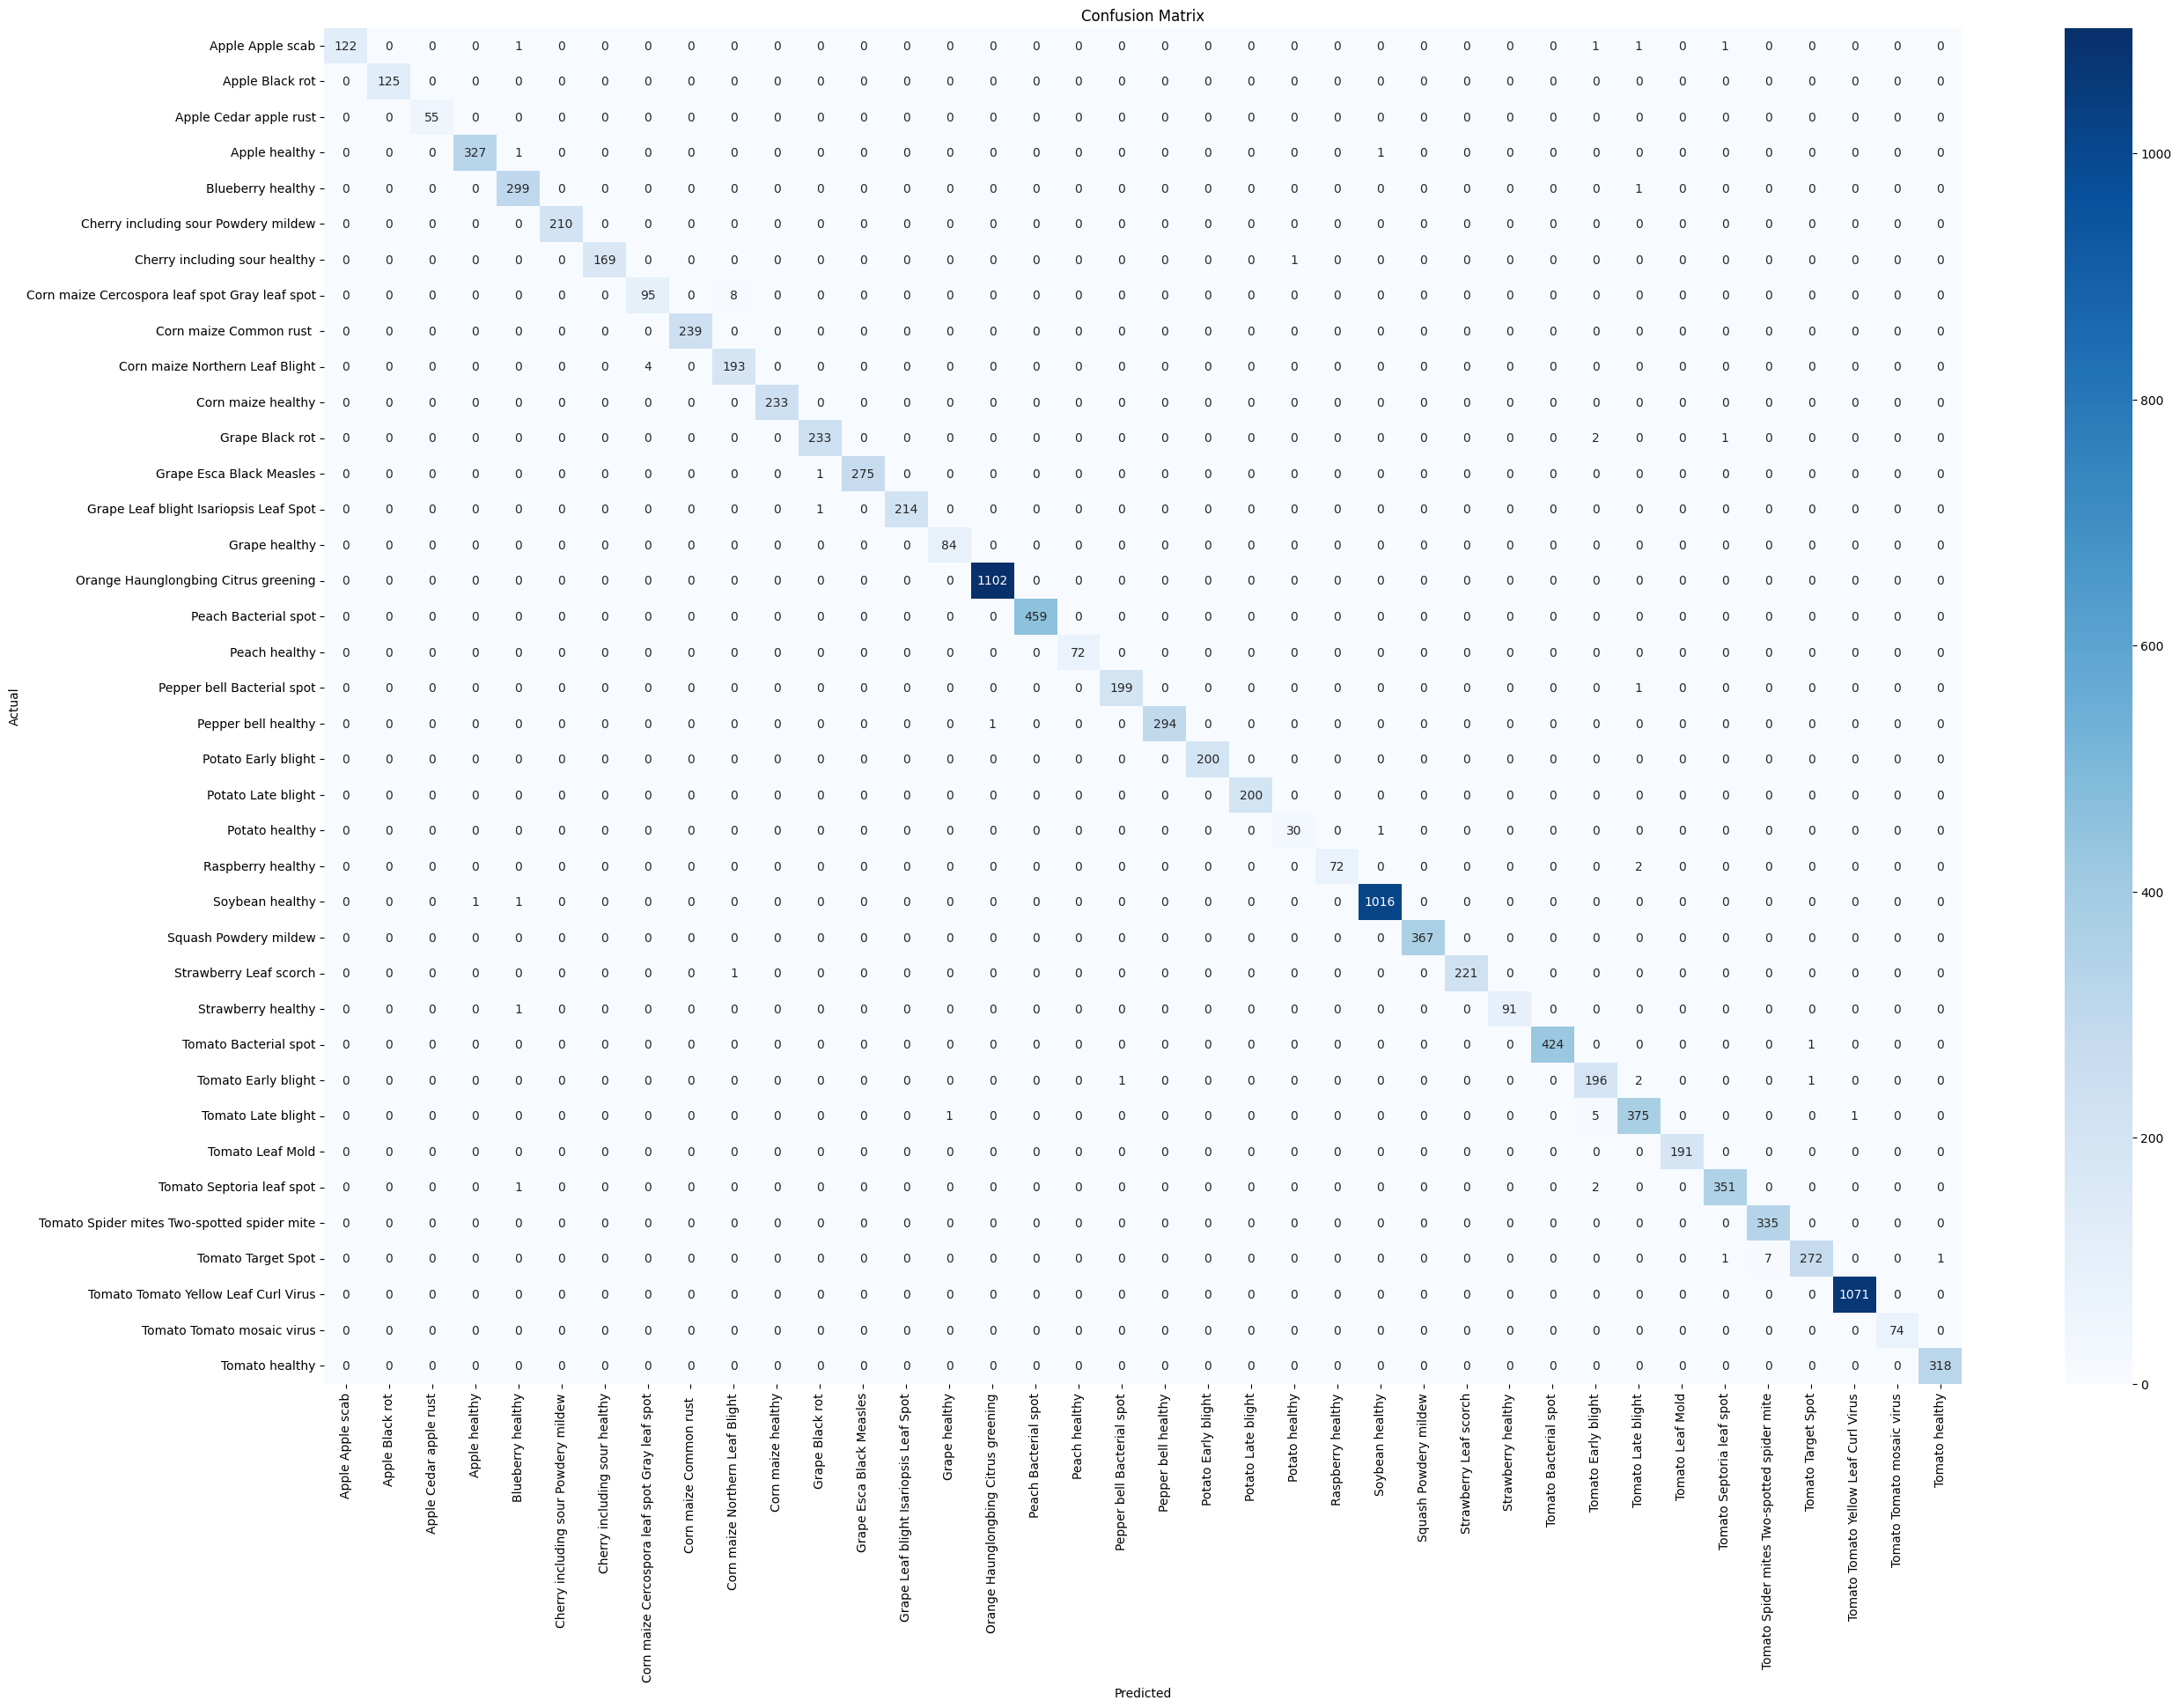

In [42]:
# Collect predictions and true labels
true_labels = []
predictions = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(pred.cpu().numpy())

# Compute confusion matrix
matrix = confusion_matrix(true_labels, predictions)

# Get class name from label index
class_name = test_dataset.classes

# Plot heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_name, yticklabels=class_name, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can see that the model can correctly classify all the classes properly.

## **Latency & Throughput Evaluation**

We measure the model's inference performance using a batch of dummy inputs to evaluate how efficiently it processes data.  
This helps to estimate **latency (time per batch)** and **throughput (images processed per second)** during inference.

In [ ]:
# Creating fake batch of images
dummy_samples = torch.ones(256, 3, 224, 224).to(device)

model.eval()
# to finish all above works first
torch.cuda.synchronize()
starting_time = time.time()

with torch.inference_mode():
    _ = model(dummy_samples)

# Complete all GPU works before processing below line by CPU
torch.cuda.synchronize()
finish_time = time.time()

# Total time per batch
total_time = finish_time - starting_time

# Throughput
throughput = int(256/total_time)

print(f"Time Per Batch: {total_time*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} img/sec")